In [ ]:
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

sns.set(style='whitegrid')

## Exploratory Data Analysis

In [ ]:
from pathlib import Path

# Default path found in workspace notebook; change if needed
DATA_PATH = Path("/content/drive/MyDrive/covid_19_classification/Train.csv").expanduser()
print('Default DATA_PATH =', DATA_PATH)

# If file not found here, upload or set the path to your CSV
if not DATA_PATH.exists():
    print('\nWarning: DATA_PATH non trouvé.')
    print('Veuillez changer le chemin d\'accès')
else:
    print('Fichier trouvé')

Default DATA_PATH = /content/drive/MyDrive/covid_19_classification/Train.csv
Fichier trouvé


In [ ]:
# Load dataset
try:
    df = pd.read_csv(DATA_PATH)
    print('Chargé:', DATA_PATH)
    print('Shape:', df.shape)
except Exception as e:
    print('Echec de chargement:', e)
    df = None

Chargé: /content/drive/MyDrive/covid_19_classification/Train.csv
Shape: (5287, 3)


In [ ]:
# Initial inspection
if df is not None:
    display(df.head(10))
    display(df.info())
    display(df.describe(include='all').T)
    print('\nColonnes:', df.columns.tolist())
    print('\nDonnées manquantes par conlonne:\n', df.isnull().sum())
else:
    print('Aucun dataframe à inspecter.')

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0
5,train_5,FIFA has proposed allowing teams to make up to...,0
6,train_6,Lovers of sports especially do you know why so...,0
7,train_7,ig he kinda cute sometimes smh,0
8,train_8,Frontline health workers are critical in the f...,1
9,train_9,Contact centers are getting overwhelmed with c...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5287 non-null   object
 1   text    5287 non-null   object
 2   target  5287 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,5287,5287,train_6860,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,5287,5287,Interest Rate Swap Derivative Pricing in Pytho...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,5287.0,NaN,NaN,NaN,0.480613,0.499671,0.0,0.0,0.0,1.0,1.0



Colonnes: ['ID', 'text', 'target']

Données manquantes par conlonne:
 ID        0
text      0
target    0
dtype: int64


In [ ]:
# Data cleaning basics
if df is not None:
    # Standardize column names
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    # Strip whitespace from object columns
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip()
    # Remove exact duplicates
    n_before = len(df)
    df = df.drop_duplicates()
    print(f'Supprimé {n_before - len(df)} lignes dupliquées')
else:
    print('Aucun dataframe à nettoyer')

Supprimé 0 lignes dupliquées


,missing_count,missing_pct
id,0,0.0
text,0,0.0
target,0,0.0


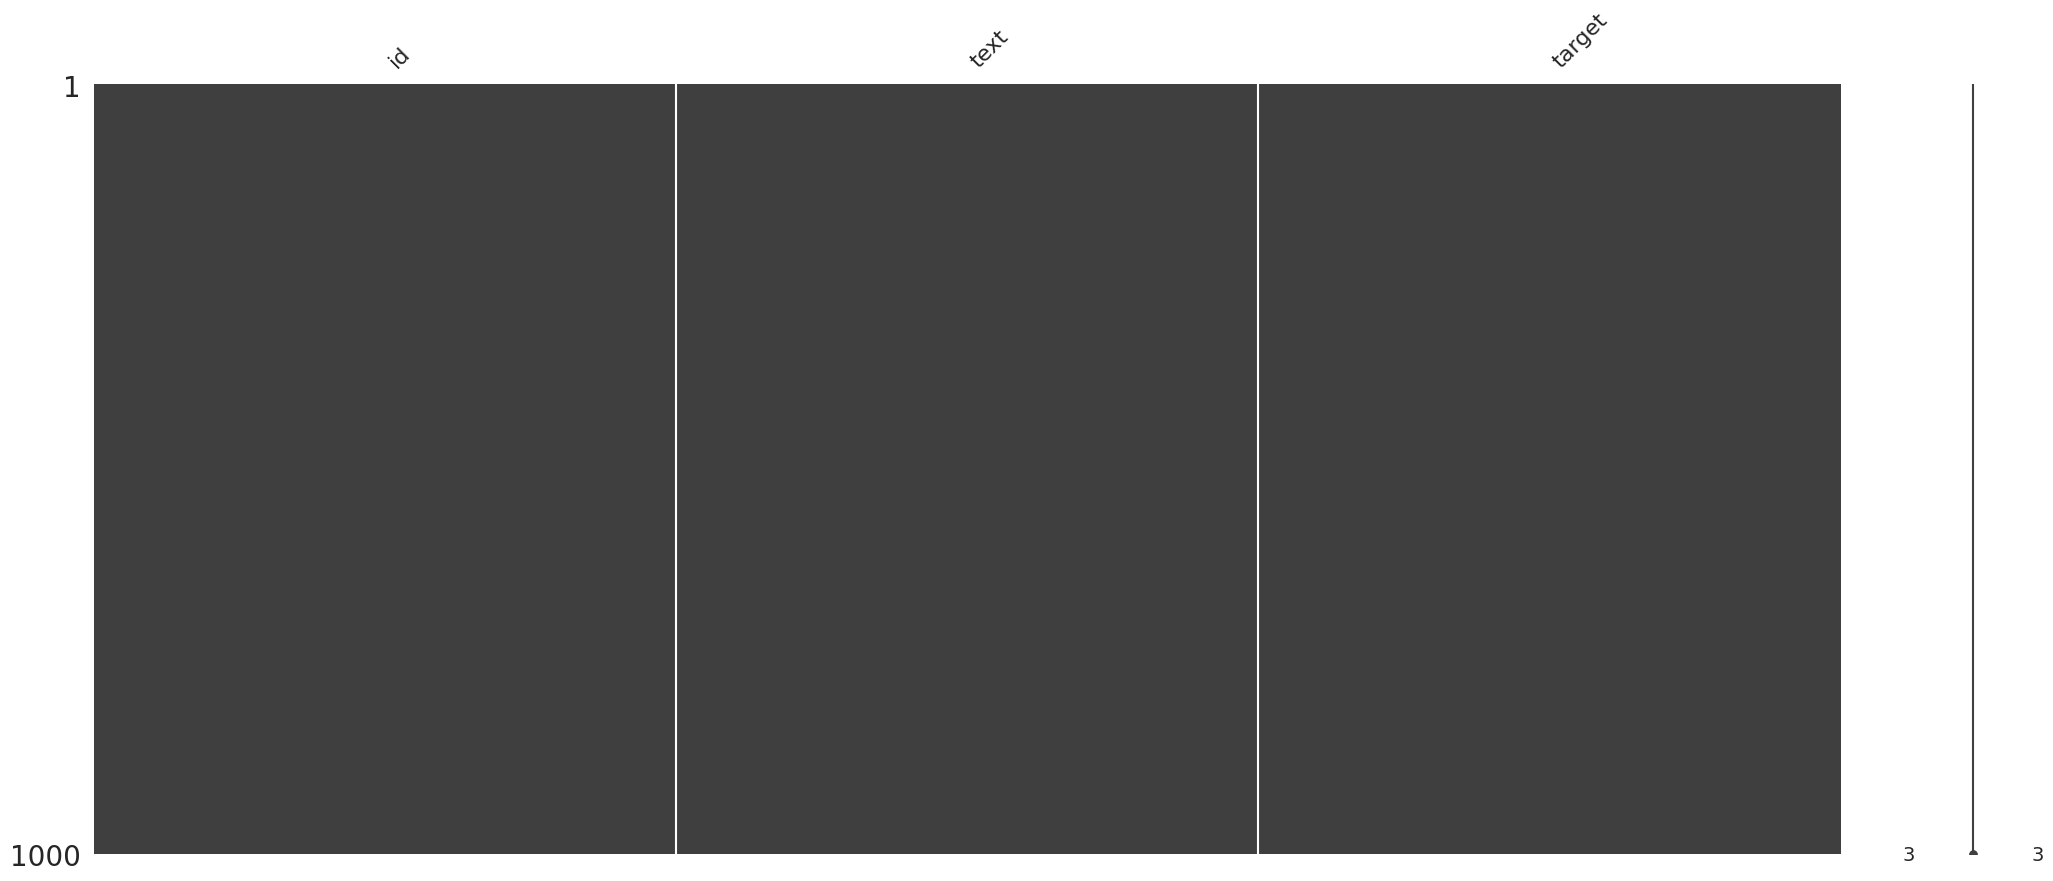

In [ ]:
# Missing values analysis
if df is not None:
    miss = df.isnull().sum().sort_values(ascending=False)
    miss_pct = (miss / len(df) * 100).round(2)
    missing_df = pd.DataFrame({'missing_count': miss, 'missing_pct': miss_pct})
    display(missing_df.head(30))
    try:
        import missingno as msno
        msno.matrix(df.sample(min(1000, len(df))))
        plt.show()
    except Exception:
        print('missingno non disponible, echec d\'affichage.')
else:
    print('Aucun dataframe pour l\'analyse des données manquantes')

In [ ]:
# Descriptive statistics
if df is not None:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    print('Numeric columns:', num_cols)
    print('Categorical columns (sample):', cat_cols[:10])
    display(df[num_cols].describe().T)
    # Categorical summaries
    for c in cat_cols[:6]:
        print('\n===', c, '===')
        print(df[c].value_counts(dropna=False).head(10))
else:
    print('Aucun dataframe pour l\'analyse descriptive.')

Numeric columns: ['target']
Categorical columns (sample): ['id', 'text']


,count,mean,std,min,25%,50%,75%,max
target,5287.0,0.480613,0.499671,0.0,0.0,0.0,1.0,1.0



=== id ===
id
train_6860    1
train_0       1
train_1       1
train_2       1
train_3       1
train_4       1
train_5       1
train_6836    1
train_6834    1
train_6833    1
Name: count, dtype: int64

=== text ===
text
Orbit is here for you during We will get through this pandemic                                                                                                                                                                               2
We know its not about the less deadly than the flu So whats REALLY going on Boris Financial Collapse Reset of the Currency System                                                                                                            1
Eng reopens more than 500 garment factories after a month long shutdown due to the pandemic while                                                                                                                                            1
Call me crazy but I love food I just hate eating               

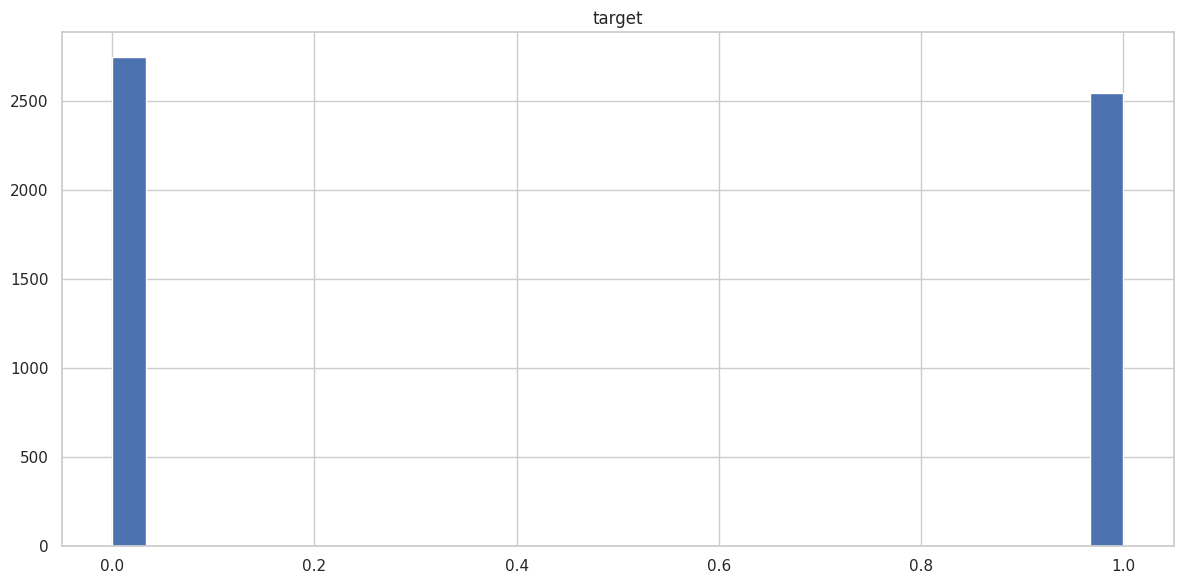

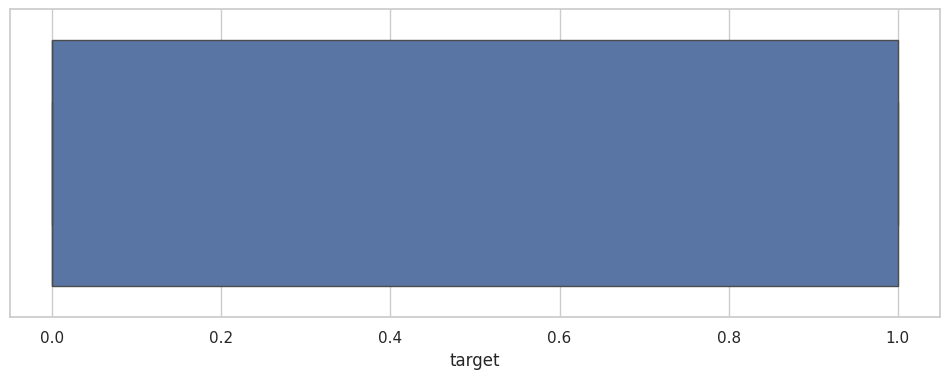

In [ ]:
# Univariate distributions for numeric columns (sample)
if df is not None and len(num_cols)>0:
    sample_nums = num_cols[:6]
    df[sample_nums].hist(bins=30, figsize=(12,6))
    plt.tight_layout()
    plt.show()
    # Boxplots
    fig, axes = plt.subplots(1, min(3,len(sample_nums)), figsize=(12,4))
    axes = np.atleast_1d(axes)  # ensures indexing works even with a single subplot
    for i,c in enumerate(sample_nums[:3]):
        sns.boxplot(x=df[c], ax=axes[i])
    plt.show()
else:
    print('Aucun dataframe ou colonnes')

Using target column: target


,count
target,
0,2746
1,2541


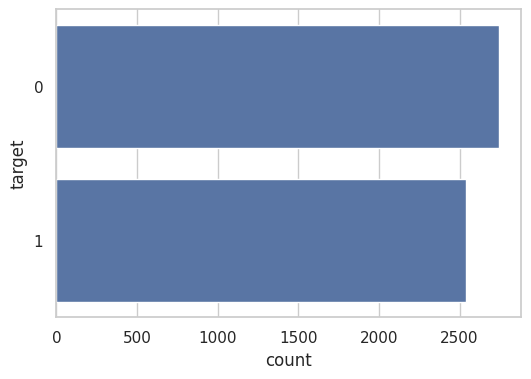

In [ ]:
# Categorical analysis and target distribution
# Attempt to detect a likely target column named 'label' or 'target'
target_candidates = [c for c in df.columns if c in (['label','target','class','sentiment'])]
if df is not None and len(target_candidates)>0:
    target = target_candidates[0]
    print('Using target column:', target)
    display(df[target].value_counts(dropna=False))
    plt.figure(figsize=(6,4))
    sns.countplot(y=target, data=df, order=df[target].value_counts().index)
    plt.show()
else:
    print('No obvious target column found. Examples:', df.columns.tolist()[:10] if df is not None else [])

In [ ]:
# Save cleaned dataset and EDA summary
if df is not None:
    out_clean = Path('cleaned_dataset.csv')
    df.to_csv(out_clean, index=False)
    print('Saved cleaned dataset to', out_clean)
    # Save a short summary
    summary = {
        'n_rows': len(df),
        'n_cols': df.shape[1],
        'missing_perc': (df.isnull().sum()/len(df)*100).to_dict()
    }
    pd.Series(summary).to_csv('eda_summary.csv')
    print('Saved EDA summary to eda_summary.csv')
else:
    print('No dataframe to save')

Saved cleaned dataset to cleaned_dataset.csv
Saved EDA summary to eda_summary.csv


## Fine tuning

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_temp = pd.read_csv('/content/cleaned_dataset.csv')
df2 = train_temp.dropna(subset=[target]).copy()
# Use the DataFrame's rename method
df2 = df2.rename(columns={'target': 'labels'})

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
import evaluate


# 1. Load Tokenizer and Model
model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 2. Preprocessing Function
def tokenize_function(examples):
    # Padding='max_length' ensures consistency; truncation prevents errors
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# 3. Prepare your data (Assuming a pandas DataFrame 'df')
train, val = train_test_split(df2, test_size=0.20, stratify=df2['labels'], random_state=42)
print('Shapes (train, val, test):', train.shape, val.shape)

# Save CSVs for fine-tuning pipelines
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
print('Saved train.csv, val.csv, test.csv')

# dataset = Dataset.from_pandas(df).map(tokenize_function, batched=True)
ds_train = Dataset.from_pandas(train)
ds_val = Dataset.from_pandas(val)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: google-bert/bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Shapes (train, val, test): (4229, 3) (1058, 3)
Saved train.csv, val.csv, test.csv


In [ ]:
tokenized_train = ds_train.map(tokenize_function, batched=True)
tokenized_val = ds_val.map(tokenize_function, batched=True)

Map:   0%|          | 0/4229 [00:00<?, ? examples/s]

Map:   0%|          | 0/1058 [00:00<?, ? examples/s]

In [ ]:
# 4. Define Metrics (Accuracy + F1 is best for binary)
metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 5. Training Arguments (The "Brain" of the pipeline)
training_args = TrainingArguments(
    output_dir="./bert-binary-results",
    learning_rate=2e-5,          # Small LR to prevent catastrophic forgetting
    per_device_train_batch_size=16,
    num_train_epochs=3,        # 3 is usually the "sweet spot"
    eval_strategy="steps",
    logging_steps=50,
    eval_steps=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=True,
    save_strategy="steps",   # Must match eval_strategy
    save_steps=50,           # Must match eval_steps
    save_total_limit=2
)
# 6. The Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,F1
50,0.513589,0.336461,0.853801
100,0.341898,0.270613,0.886275
150,0.245192,0.273189,0.897727
200,0.232385,0.257377,0.910134
250,0.253020,0.249913,0.904762
300,0.157238,0.274059,0.920696
350,0.164958,0.269875,0.918447
400,0.158406,0.285383,0.911907
450,0.175642,0.275917,0.917715
500,0.148492,0.274395,0.907816


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=795, training_loss=0.18123793452040954, metrics={'train_runtime': 310.8741, 'train_samples_per_second': 40.811, 'train_steps_per_second': 2.557, 'total_flos': 834522489838080.0, 'train_loss': 0.18123793452040954, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()

In [ ]:
# Check if it worked
print(eval_results)

{'eval_loss': 0.2503088712692261, 'eval_f1': 0.9047619047619048, 'eval_runtime': 2.415, 'eval_samples_per_second': 438.1, 'eval_steps_per_second': 55.073, 'epoch': 3.0}


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

model_names = ["roberta-base", "microsoft/deberta-v3-base"]
results = {}

def train_and_evaluate(model_name, use_fp16):
    print(f"\n--- Starting Training for {model_name} ---")

    # 1. Load Tokenizer and Model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # 2. Tokenize (Note: RoBERTa/DeBERTa often don't use 'token_type_ids')
    def tokenize_func(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    tokenized_train = ds_train.map(tokenize_func, batched=True)
    tokenized_val = ds_val.map(tokenize_func, batched=True)

    # 3. Setup Trainer (Reuse your optimized TrainingArguments)
    args = TrainingArguments(
        output_dir=f"./results_{model_name.split('/')[-1]}",
        learning_rate=2e-5,
        num_train_epochs=3,
        logging_steps = 50,
        eval_strategy="steps",
        eval_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        fp16=use_fp16, # Recommended for speed
        bf16= not(use_fp16),
        report_to="none" # Prevents cluttering logs
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer.evaluate()

# Execute the loop
for name in model_names:
    # DeBERTa v3 is notoriously picky with fp16
    use_fp16 = False if "deberta" in name.lower() else True
    results[name] = train_and_evaluate(name, use_fp16)
    print(results[name])


--- Starting Training for roberta-base ---


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/4229 [00:00<?, ? examples/s]

Map:   0%|          | 0/1058 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,F1
50,0.613363,0.415389,0.828797
100,0.435326,0.323229,0.884972
150,0.321038,0.337434,0.890960
200,0.402321,0.255014,0.902857
250,0.349960,0.374486,0.879433
300,0.238717,0.381177,0.896353
350,0.324438,0.339265,0.898438
400,0.313526,0.250049,0.911513
450,0.283256,0.340401,0.913416
500,0.243855,0.329295,0.911619


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

{'eval_loss': 0.3007757067680359, 'eval_f1': 0.9239653512993262, 'eval_runtime': 2.2851, 'eval_samples_per_second': 462.995, 'eval_steps_per_second': 58.203, 'epoch': 3.0}

--- Starting Training for microsoft/deberta-v3-base ---


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.bias             | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
classifier.bias                         | MISSING    | 
classifier.weight                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
pooler.dense.bias        

Map:   0%|          | 0/4229 [00:00<?, ? examples/s]

Map:   0%|          | 0/1058 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,F1
50,1.462980,2.533719,0.648787
100,2.029200,0.699615,0.000000
150,0.879544,0.812299,0.000000
200,0.878559,0.739783,0.648787
250,0.842926,0.702327,0.648787
300,0.761622,0.805081,0.648787
350,0.788485,0.747231,0.000000
400,0.856627,0.697189,0.648787
450,0.773430,0.703756,0.000000
500,0.723748,0.801812,0.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6923955082893372, 'eval_f1': 0.0, 'eval_runtime': 12.6565, 'eval_samples_per_second': 83.593, 'eval_steps_per_second': 10.508, 'epoch': 3.0}


In [ ]:
# 4. Define Metrics (Accuracy + F1 is best for binary)
model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', num_labels=2)
metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 5. Training Arguments (The "Brain" of the pipeline)
training_args = TrainingArguments(
    output_dir="./deberta-binary-results",
    learning_rate=1e-5,          # Small LR to prevent catastrophic forgetting
    warmup_ratio=0.1,
    num_train_epochs=3,        # 3 is usually the "sweet spot"
    eval_strategy="steps",
    logging_steps=10,
    eval_steps=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=False,
    metric_for_best_model="f1"
)
# 6. The Trainer
trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.bias             | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
classifier.bias                         | MISSING    | 
classifier.weight                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
pooler.dense.bias        

Step,Training Loss,Validation Loss,F1
50,0.690855,0.725626,0.000000
100,0.727107,0.694065,0.648787
150,0.715011,0.710279,0.000000
200,0.741324,0.760378,0.648787
250,0.000000,nan,0.000000
300,0.000000,nan,0.000000
350,0.000000,nan,0.000000
400,0.000000,nan,0.000000
450,0.000000,nan,0.000000
500,0.000000,nan,0.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=1587, training_loss=0.10747420389695819, metrics={'train_runtime': 349.5441, 'train_samples_per_second': 36.296, 'train_steps_per_second': 4.54, 'total_flos': 834537456032256.0, 'train_loss': 0.10747420389695819, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
output = trainer.predict(tokenized_val)
preds = np.argmax(output.predictions, axis=-1)

# This will show Precision and Recall for BOTH classes
print(classification_report(output.label_ids, preds))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       550
           1       0.00      0.00      0.00       508

    accuracy                           0.52      1058
   macro avg       0.26      0.50      0.34      1058
weighted avg       0.27      0.52      0.36      1058



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Freezing

In [ ]:
from transformers import AutoModelForSequenceClassification

# 1. Load the model
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)

# 2. Freeze the backbone
# For DeBERTa, the backbone is called 'deberta'
for name, param in model.deberta.named_parameters():
    param.requires_grad = False

# 3. Verification: Check what is actually training
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {trainable_params:,}")
# You should see ~600k to 1M parameters instead of 184M!

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.bias             | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
classifier.bias                         | MISSING    | 
classifier.weight                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
pooler.dense.bias        

Total Trainable Parameters: 592,130


In [ ]:
training_args = TrainingArguments(
    output_dir="./frozen-deberta-results",
    learning_rate=1e-4,           # We use a LARGER LR here because the head needs more 'push'
    per_device_train_batch_size=16,
    num_train_epochs=3,           # You might need more epochs now that the backbone is frozen
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=False                    # Stay safe with FP32
)

In [ ]:
# 6. The Trainer
trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,F1
50,2.514068,3.839072,0.431461
100,1.454406,4.421483,0.571429
150,2.322637,1.210351,0.458547
200,0.895615,1.093275,0.337165
250,0.855409,0.839079,0.176282
300,0.878271,0.842813,0.231231
350,0.867245,0.833172,0.313158
400,0.740864,0.807417,0.405830
450,0.709630,0.770830,0.344913
500,0.743309,0.729199,0.185008


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=795, training_loss=1.1692094988792947, metrics={'train_runtime': 110.0295, 'train_samples_per_second': 115.305, 'train_steps_per_second': 7.225, 'total_flos': 834537456032256.0, 'train_loss': 1.1692094988792947, 'epoch': 3.0})